# Generative Adverserial Network :  MLP - Keras

In this notebook we will be looking at how to build a very simple Generative Adversarial Network using MultiLayer Perception in Keras. We will be working with the MNIST dataset. This implementation is based on the following paper : 

Reference : https://arxiv.org/abs/1406.2661

Also, the following blog post does a good job of giving an intro to GANs - 

Reference : https://www.analyticsvidhya.com/blog/2017/06/introductory-generative-adversarial-networks-gans/

**Note**

In this notebook, we will *NOT* be using the inbuilt adversarial networks of Keras since we want to learn how to implement them ourselves.

## Imports

In [52]:
from __future__ import division,print_function
from PIL import Image
import gc,re

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

from keras.models import Model, Sequential
from keras.layers import Input, Dense
#from keras.layers.merge import Add
from keras.optimizers import Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from importlib import reload
from keras import backend as K
from keras.datasets import imdb

np.random.seed(7)

from keras.preprocessing.image import load_img, img_to_array

import bcolz
from IPython.display import FileLink
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

from scipy.optimize import fmin_l_bfgs_b
from keras import metrics
from scipy.misc import imsave
import imageio

%matplotlib inline

### Load dataset

In [3]:
def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
limit_mem()

In [98]:
from keras.datasets import mnist

(X_train, y_train), (X_test,y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

Let us look at a few of the images in this dataset.

In [99]:
def plot(im):
    fig = plt.figure(figsize=(7,7))
    for i, img in enumerate(im):
        a = fig.add_subplot(4,4,i+1)
        plt.imshow(img, cmap='gray')

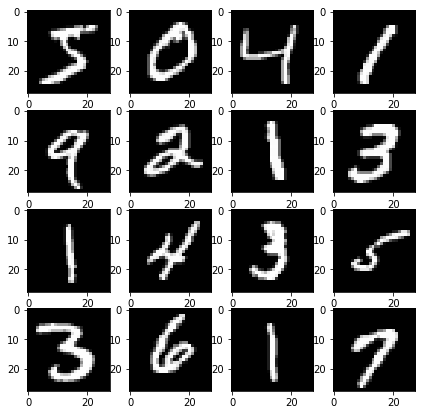

In [100]:
plot(X_train[:16])

In [101]:
n = len(X_train)
n

60000

We have 60,000 images of digits in our training dataset. Now, currently each example in X_train is 28x28 image. Let us flatten that into a 28 * 28 = 784 array of floats. We need to do this because we are working with Dense layers only.

In [102]:
X_train = X_train.reshape(n,-1).astype(np.float32)

In [103]:
X_train.shape

(60000, 784)

In [120]:
X_train /= 255

## GANs ' - Overview

Now, let us look at a high level overview of GANs'.

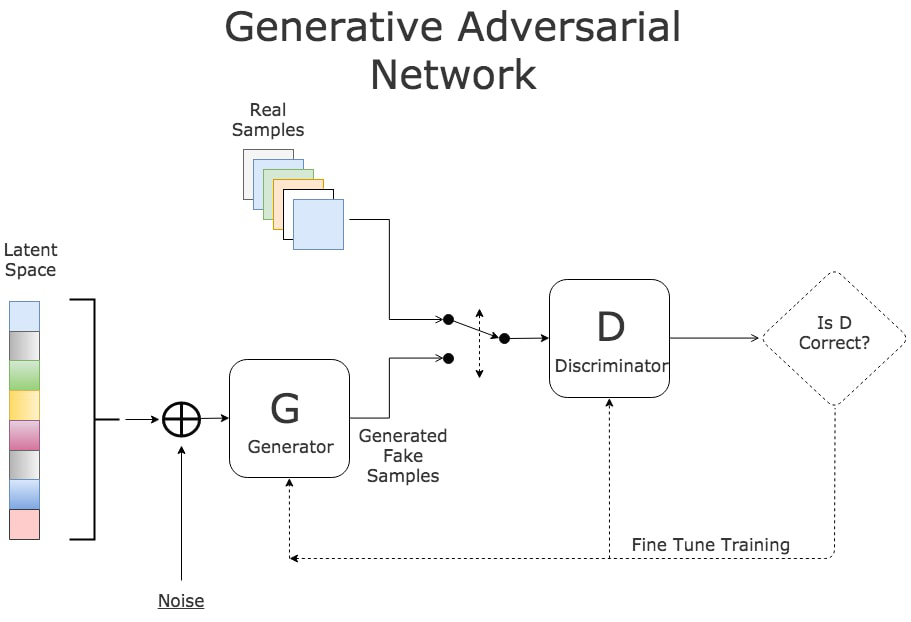

In [121]:
PATH = 'data/GAN/'
Image.open(PATH + 'gan.jpg')

So this is what a Generative Adversarial Network is. It consists of two key components - a Generator (G) and a Discriminator (D).

The job of the Discriminator is to distinguish between fake and real samples. The job of the Generator is to create samples from noise which are so close to the real samples so as to fool the Discriminator.

Let us try to make sense of this with an analogy -

Let us assume that there is an amateur detective and an amateur forger. Now, the objective of the forger is to create paintings which look very close to the actual paintings by the artists. The objective of the detective is to distinguish between fake and real paintings. 

Now, the forger creates a painting and gives it to the detective. The detective then looks at the painting and decides whether it is real or fake. Now, with this decision, the forger can try and improve his forgery and the detective and try and improve his decisions. This cat and mouse game keeps on going between the two of them and eventually both of them start improving.

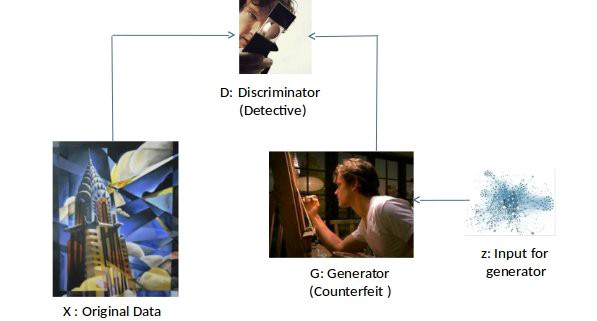

In [122]:
Image.open(PATH + 'gan2.jpeg')

## Helper Functions

Now, the generator requires noise as input. We are creating a method which returns 'n_examples' noisy arrays, each with 100 values.

In [123]:
g_inp_dim = 100
batch_size = 128
n_epochs = 1000

In [124]:
def get_noise_for_G(n_examples):
    noise = np.random.rand(n_examples, g_inp_dim)
    return noise

Now, as we can see, the data that gets fed into the Discriminator is a mixture of real and fake samples, along with their labels.

Here, we are taking 'n_samples' number of real images from the train dataset and we are generating an equal amount of fake data. We then label the real data with zeros and the fake data with ones.

In [125]:
def get_data_for_D(n_samples, G):
    X_real = X_train[np.random.randint(0,n,size=n_samples)]
    X_fake = G.predict(get_noise_for_G(n_samples))
    
    X = np.concatenate((X_real, X_fake))
    
    y_real = [0]*n_samples    # 0 is for real
    y_fake = [1]*n_samples    # 1 is for fake
    y = y_real + y_fake
    
    return X,y

Now, while training the Discriminator, we dont want to update the weights of the Generator. And vice versa, while training the Generator, we dont want to update the weights of the Discriminator.

In [138]:
def make_trainable(model, val):
    model.trainable = val
    for layer in model.layers:
        layer.trainable = val
    #model.compile(optimizer='adam', loss='binary_crossentropy')

Now, let us define a custom train method which allows us to train the Discriminator and the Generator one by one for a few thousand epochs.

In [140]:
from tqdm import tqdm
def train(D,G,m,epochs=n_epochs, batch_size = 128, n_samples = 64):
    dl, gl = [],[]
    for i in tqdm(range(epochs)):
        
        X,y = get_data_for_D(n_samples, G)
        dl.append(D.train_on_batch(X,y))
        
        # After training the Discriminator, we want to train the Generator. 
        # We dont want to modify the Discriminator while doing that.
        make_trainable(D,False)
        
        X_G = get_noise_for_G(batch_size)
        y_G = [0]*batch_size   # we want the generator to generate images which look real
        gl.append(m.train_on_batch(X_G,y_G))
        
        # After training the Generator, we want to train the Discriminator. 
        make_trainable(D, True)
    return dl,gl

## Create Models

### Create Generator MLP

The generator has 784 as the output shape because we want the generator to create a 28x28 image.

In [141]:
inp = Input(shape=(g_inp_dim,), name="input_G")
x = Dense(200, activation='relu')(inp)
x = Dense(400, activation='relu')(x)
outp = Dense(784, activation='sigmoid')(x)

MLP_G = Model(inputs=inp, outputs=outp)

In [142]:
MLP_G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_G (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 200)               20200     
_________________________________________________________________
dense_35 (Dense)             (None, 400)               80400     
_________________________________________________________________
dense_36 (Dense)             (None, 784)               314384    
Total params: 414,984
Trainable params: 414,984
Non-trainable params: 0
_________________________________________________________________


### Create Discriminator MLP

The input to the discriminator is of shape 784 since we will be feeding it a flattened image of 28x28. Its output is of shape 1 since it has to decide whether an image is fake or real.

In [143]:
inpD = Input(shape=(784,), name="Input_D")
x = Dense(400, activation='relu')(inpD)
x = Dense(400, activation='relu')(x)
outpD = Dense(1, activation='sigmoid')(x)

MLP_D = Model(inputs=inpD, outputs=outpD)
MLP_D.compile(optimizer='adam', loss='binary_crossentropy')

In [144]:
MLP_D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_D (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 400)               314000    
_________________________________________________________________
dense_38 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 401       
Total params: 474,801
Trainable params: 474,801
Non-trainable params: 0
_________________________________________________________________


### Combine Generator (G) and Discriminator (D)

Now, for the generative flow, we need to combined both G and D in a sequence since the output of G should be fed into D.

In [145]:
MLP_C = Sequential([MLP_G,MLP_D])
MLP_C.compile(optimizer='adam', loss='binary_crossentropy')

In [146]:
MLP_C.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_14 (Model)             (None, 784)               414984    
_________________________________________________________________
model_15 (Model)             (None, 1)                 474801    
Total params: 889,785
Trainable params: 889,785
Non-trainable params: 0
_________________________________________________________________


In [147]:
train(MLP_D,MLP_G, MLP_C, epochs=4000)

  0%|          | 0/4000 [00:00<?, ?it/s]/home/kshitijg1992/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 4000/4000 [01:03<00:00, 62.99it/s]


([0.72989106,
  0.75218379,
  0.87732387,
  1.1058364,
  1.4072692,
  1.6796424,
  1.9892412,
  2.2130017,
  2.3850958,
  2.4778502,
  2.5459695,
  2.595226,
  2.571003,
  2.5054653,
  2.3935013,
  2.2706873,
  2.1322691,
  1.9975966,
  1.8697288,
  1.7476668,
  1.6708696,
  1.6305825,
  1.6299533,
  1.631781,
  1.6600509,
  1.6712403,
  1.6585243,
  1.653558,
  1.6680186,
  1.6963007,
  1.7150197,
  1.7209133,
  1.709566,
  1.7006197,
  1.6899059,
  1.6822438,
  1.6724336,
  1.6522667,
  1.6294127,
  1.6163981,
  1.6031692,
  1.592005,
  1.5826367,
  1.5735211,
  1.5635662,
  1.5590732,
  1.5559323,
  1.560811,
  1.5682023,
  1.5744689,
  1.5776017,
  1.5888684,
  1.6100167,
  1.6067266,
  1.6076882,
  1.6000166,
  1.5865972,
  1.5727034,
  1.5604032,
  1.533093,
  1.5127995,
  1.4985741,
  1.4856653,
  1.4866991,
  1.4822756,
  1.4918737,
  1.4965407,
  1.5006598,
  1.5064142,
  1.5174253,
  1.5233276,
  1.5230789,
  1.512629,
  1.4953332,
  1.4877123,
  1.4930542,
  1.482089,
  1.44

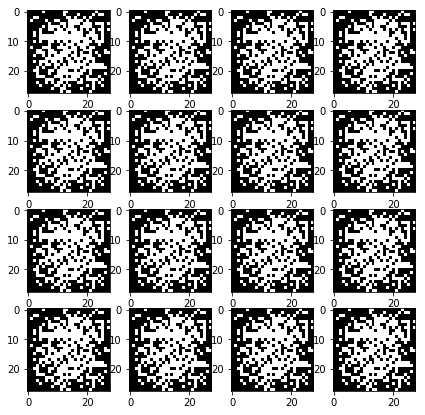

In [135]:
plot(MLP_G.predict(get_noise_for_G(16)).reshape(16, 28,28))

As we can see, the output of the Generator is basically the same? Why is this happening? Is the generator not learning anything?

This is because of something called **Mode Collapse**.

Basically, the generator and the discriminator have reached a stalemate. In the ideal scenario, both the generator and the discriminator should be learning something useful from each other, thereby improving each other. But in the case of mode collapse, they reach a stalemate.

Here is a very good explanation of what mode collapse is all about : 

Reference : http://aiden.nibali.org/blog/2017-01-18-mode-collapse-gans/#fn:imprgan

In out next notebook, we will study another variation of GANs called DCGANs' which help with overcoming mode collapses and stalemates.